In [1]:
import torch, shap, glob
import numpy as np, pandas as pd, torchvision.transforms as transforms
import random

from feedback import *
from tqdm.notebook import tqdm
from torchvision.models import alexnet
from torch.nn import Module
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image

np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

In [2]:
npy_path = './np_image_totalunit/binaryclass_nactg_200px/'
# npy_path = './np_image_totalunit/multiclass_totalunit/'

save_weight_path ='./models/weights_binaryclass_Covid19(Non-kmer3)_IndexRemark.2022.04.14[NATCG]_200px/'
if not os.path.exists(save_weight_path):
    os.mkdir(save_weight_path)

# save_weight_path = './models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.24[NACGTRYKMSWBDHV]/'

weights_name = "weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.04.14.pt"
# weights_name = "weights_Multiclass_Covid19(Non-kmer3)[NACGTRYKMSWBDHV].2022.03.24.pt"

path2weights = os.path.join(save_weight_path,weights_name)

In [3]:
npy_data_list = [os.path.join(npy_path,'image_npy',i ) for i in sorted(os.listdir(os.path.join(npy_path,'image_npy')))]
label_ = np.load(os.path.join(npy_path,'label.npy'))

In [13]:
label_[0:30]

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1])

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(npy_data_list, label_,stratify = label_, test_size=0.25, random_state=42)

print(len(X_train), len(y_train)) 

print(len(X_test), len(y_test))

1053 1053
351 351


In [5]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class TransferDataset(Dataset):
    def __init__(self, s_path, labels, transform):
        self.transform = transform
        self.s_path = s_path
        self.labels = labels
        
    def __len__(self):
        return len(self.s_path)

    def __getitem__(self, idx):
        singel_image_ = np.load(self.s_path[idx]).astype(np.float32)
        seed = np.random.randint(1e9)       
        random.seed(seed)
        np.random.seed(seed)
        singel_image_ = self.transform(singel_image_)
        label = int(self.labels[idx])
        # print(label)

        return singel_image_, label

In [6]:
transformer = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(mean, std),
            ])     

train_ds = TransferDataset(s_path= X_train, labels= y_train, transform= transformer)
test_ds = TransferDataset(s_path= X_test, labels= y_test, transform= transformer)
print(len(train_ds), len(test_ds))

1053 351


In [8]:
from torchvision.models import alexnet
from torch.nn import Module
from torch import nn
model = alexnet(pretrained=False, num_classes=max(label_)+1)
# model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# model

In [9]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# loss_func = nn.CrossEntropyLoss(reduction="sum", weight=class_weights)
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
os.makedirs("./models", exist_ok=True)
# path2weights = "./models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.22.pt"
# torch.save(model.state_dict(), path2weights)
params_train={
    "num_epochs": 150,
    "optimizer": opt,
    "loss_func": loss_func,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2weights,
    }

In [10]:
import copy
import datetime
from tqdm import tqdm_notebook
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

class logs_realtime_reply:
    def __init__(self):
        self.avg_loss=np.inf
        self.running_metic = {"Loss":0, "Accuracy":0}
        self.end_epoch_metric = None
    def metric_stack(self, inputs, targets, loss):

        classes = torch.argmax(inputs, dim=1)
        self.running_metic['Loss'] +=loss
        classes = torch.argmax(inputs, dim=1)
        acc = torch.mean((classes == targets).float())
        # print(acc)
        self.running_metic['Accuracy'] += np.round(acc.cpu() .numpy(), 5)*100
    def mini_batch_reply(self, current_step, epoch, iter_len):
        # avg_reply_metric = {"Loss":None, "TP":None, "FP":None, "FN": None, "Spec": None, "Sens": None}
        avg_reply_metric = {"Loss":None, "Accuracy": None}
        for j in avg_reply_metric:
            avg_reply_metric[j] = round(self.running_metic[j]/int(current_step),5)
        
        if current_step ==iter_len:
            self.end_epoch_metric = avg_reply_metric
        return avg_reply_metric
    def epoch_reply(self):
        return self.end_epoch_metric
        
def train(train_loader, model, criterion, optimizer, epoch):
    get_logs_reply = logs_realtime_reply()
    model.train()
    stream = tqdm(train_loader)
   
    for i, (image, label) in enumerate(stream, start=1):
        image=image.to(device)
        label=label.to(device)
        output=model(image)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        clip_gradient(optimizer, 0.5)
        optimizer.step()
        
        get_logs_reply.metric_stack(output, label, loss = round(loss.item(), 5))
        avg_reply_metric = get_logs_reply.mini_batch_reply(i, epoch, len(stream))
        avg_reply_metric['lr'] = optimizer.param_groups[0]['lr']
        stream.set_description(f"Epoch: {epoch}. Train. {str(avg_reply_metric)}")
    return avg_reply_metric['Loss'], avg_reply_metric['Accuracy']
# model validate
def validate(valid_loader, model, criterion, epoch):
    global best_vloss, best_vacc
    get_logs_reply2 = logs_realtime_reply()
    model.eval()
    stream_v = tqdm(valid_loader)
    with torch.no_grad():
        for i, (image, label) in enumerate(stream_v, start=1):
            image=image.to(device)
            label=label.to(device)
            output=model(image)
            loss = criterion(output, label)
            get_logs_reply2.metric_stack(output, label, loss = round(loss.item(), 5))
            avg_reply_metric = get_logs_reply2.mini_batch_reply(i, epoch, len(stream_v))
            stream_v.set_description(f"Epoch: {epoch}. Valid. {str(avg_reply_metric)}")
        avg_reply_metric = get_logs_reply2.epoch_reply()

    for x in avg_reply_metric:
        if x=='Loss' and avg_reply_metric[x]<best_vloss:
            best_vloss = avg_reply_metric[x]
            current_loss = avg_reply_metric['Loss']
            best_ck_name = path2weights
            torch.save({
                    'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': opt.state_dict(), 
                    'loss':  current_loss,}, best_ck_name)
            print('save...', best_ck_name)
    return avg_reply_metric['Loss'], avg_reply_metric['Accuracy']



def  train_valid_process_main(model):
    global best_vloss, best_vacc
    best_vloss = np.inf
    best_vacc = 0.00
    loss_history={
        "train": [],
        "val": [],
    }
    
    metric_history={
        "train": [],
        "val": [],
    }
    # Subject Dataloader Building
    batch_size = 32
    train_dl = DataLoader(train_ds, batch_size= batch_size, 
                            shuffle=True)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                            shuffle=False)  

    for epoch in range(1, params_train["num_epochs"] + 1):
        train_loss, train_metric = train(train_dl, model, loss_func, opt, epoch)
        val_loss, val_metric = validate(test_dl, model, loss_func, epoch)
        print("Epoch: ",epoch, f" Train/Valid Loss: {train_loss}|{val_loss}  ", f" Train/Valid Accuracy: {train_metric}|{val_metric}")
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        lr_scheduler.step(val_loss)
    return loss_history, metric_history

In [11]:
loss_history, metric_history  = train_valid_process_main(model)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_binaryclass_Covid19(Non-kmer3)_IndexRemark.2022.04.14[NATCG]_200px/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.04.14.pt
Epoch:  1  Train/Valid Loss: 21.76977|38.10768    Train/Valid Accuracy: 64.07067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  2  Train/Valid Loss: 20.92008|40.08333    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  3  Train/Valid Loss: 20.89521|40.48082    Train/Valid Accuracy: 64.42006|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  4  Train/Valid Loss: 21.20634|38.72501    Train/Valid Accuracy: 64.42006|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  5  Train/Valid Loss: 20.97696|38.11848    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_binaryclass_Covid19(Non-kmer3)_IndexRemark.2022.04.14[NATCG]_200px/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.04.14.pt
Epoch:  6  Train/Valid Loss: 21.02372|38.09868    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_binaryclass_Covid19(Non-kmer3)_IndexRemark.2022.04.14[NATCG]_200px/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.04.14.pt
Epoch:  7  Train/Valid Loss: 20.83969|37.97317    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  8  Train/Valid Loss: 20.72567|38.82893    Train/Valid Accuracy: 64.43967|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_binaryclass_Covid19(Non-kmer3)_IndexRemark.2022.04.14[NATCG]_200px/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.04.14.pt
Epoch:  9  Train/Valid Loss: 20.63785|37.83714    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_binaryclass_Covid19(Non-kmer3)_IndexRemark.2022.04.14[NATCG]_200px/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.04.14.pt
Epoch:  10  Train/Valid Loss: 20.60332|37.7403    Train/Valid Accuracy: 63.88779|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_binaryclass_Covid19(Non-kmer3)_IndexRemark.2022.04.14[NATCG]_200px/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.04.14.pt
Epoch:  11  Train/Valid Loss: 20.57046|37.64698    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  12  Train/Valid Loss: 20.38021|37.75411    Train/Valid Accuracy: 64.31558|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  13  Train/Valid Loss: 20.96997|38.09667    Train/Valid Accuracy: 63.24452|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  14  Train/Valid Loss: 20.88399|38.0983    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  15  Train/Valid Loss: 20.76701|38.55476    Train/Valid Accuracy: 64.42006|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  16  Train/Valid Loss: 21.10539|38.24611    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  17  Train/Valid Loss: 20.86564|38.14985    Train/Valid Accuracy: 64.38088|64.39833
Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  18  Train/Valid Loss: 20.80322|38.09305    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  19  Train/Valid Loss: 20.8154|38.09655    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  20  Train/Valid Loss: 20.73864|38.10008    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  21  Train/Valid Loss: 20.81322|38.09406    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  22  Train/Valid Loss: 20.76657|38.09277    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  23  Train/Valid Loss: 20.84501|38.09878    Train/Valid Accuracy: 64.39067|64.39833
Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  24  Train/Valid Loss: 20.79677|38.10663    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  25  Train/Valid Loss: 20.75733|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  26  Train/Valid Loss: 20.82233|38.09363    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  27  Train/Valid Loss: 20.78591|38.09282    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  28  Train/Valid Loss: 20.76361|38.09395    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  29  Train/Valid Loss: 20.80853|38.09384    Train/Valid Accuracy: 64.40048|64.39833
Epoch 00029: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  30  Train/Valid Loss: 20.78168|38.09289    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  31  Train/Valid Loss: 20.80787|38.09279    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  32  Train/Valid Loss: 20.74786|38.09351    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  33  Train/Valid Loss: 20.76319|38.09291    Train/Valid Accuracy: 64.41027|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  34  Train/Valid Loss: 20.78593|38.09302    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  35  Train/Valid Loss: 20.8432|38.09264    Train/Valid Accuracy: 64.39067|64.39833
Epoch 00035: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  36  Train/Valid Loss: 20.79241|38.09266    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  37  Train/Valid Loss: 20.81604|38.09265    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  38  Train/Valid Loss: 20.8154|38.09272    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  39  Train/Valid Loss: 20.82167|38.09296    Train/Valid Accuracy: 64.42985|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  40  Train/Valid Loss: 20.79195|38.09266    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  41  Train/Valid Loss: 20.81121|38.09292    Train/Valid Accuracy: 64.33191|64.39833
Epoch 00041: reducing learning rate of group 0 to 3.1250e-05.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  42  Train/Valid Loss: 20.76389|38.0928    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  43  Train/Valid Loss: 20.77839|38.09264    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  44  Train/Valid Loss: 20.79563|38.09267    Train/Valid Accuracy: 64.41027|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  45  Train/Valid Loss: 20.80423|38.09268    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  46  Train/Valid Loss: 20.79163|38.0928    Train/Valid Accuracy: 64.45924|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  47  Train/Valid Loss: 20.74828|38.09265    Train/Valid Accuracy: 64.36127|64.39833
Epoch 00047: reducing learning rate of group 0 to 1.5625e-05.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  48  Train/Valid Loss: 20.78992|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  49  Train/Valid Loss: 20.77295|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  50  Train/Valid Loss: 20.79917|38.09266    Train/Valid Accuracy: 64.42985|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  51  Train/Valid Loss: 20.7712|38.09264    Train/Valid Accuracy: 64.33191|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  52  Train/Valid Loss: 20.82142|38.09265    Train/Valid Accuracy: 64.41027|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  53  Train/Valid Loss: 20.80533|38.09265    Train/Valid Accuracy: 64.38088|64.39833
Epoch 00053: reducing learning rate of group 0 to 7.8125e-06.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  54  Train/Valid Loss: 20.74347|38.09264    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  55  Train/Valid Loss: 20.755|38.09265    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  56  Train/Valid Loss: 20.79103|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  57  Train/Valid Loss: 20.77798|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  58  Train/Valid Loss: 20.79509|38.09265    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  59  Train/Valid Loss: 20.79532|38.09265    Train/Valid Accuracy: 64.38088|64.39833
Epoch 00059: reducing learning rate of group 0 to 3.9063e-06.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  60  Train/Valid Loss: 20.8114|38.09264    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  61  Train/Valid Loss: 20.76452|38.09264    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  62  Train/Valid Loss: 20.75956|38.09264    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  63  Train/Valid Loss: 20.76891|38.09265    Train/Valid Accuracy: 64.41027|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  64  Train/Valid Loss: 20.80843|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  65  Train/Valid Loss: 20.78645|38.09264    Train/Valid Accuracy: 64.37109|64.39833
Epoch 00065: reducing learning rate of group 0 to 1.9531e-06.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  66  Train/Valid Loss: 20.79278|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  67  Train/Valid Loss: 20.79219|38.09264    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  68  Train/Valid Loss: 20.81617|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  69  Train/Valid Loss: 20.79021|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  70  Train/Valid Loss: 20.76277|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  71  Train/Valid Loss: 20.81066|38.09264    Train/Valid Accuracy: 64.42006|64.39833
Epoch 00071: reducing learning rate of group 0 to 9.7656e-07.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  72  Train/Valid Loss: 20.71271|38.09265    Train/Valid Accuracy: 64.42006|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  73  Train/Valid Loss: 20.79625|38.09264    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  74  Train/Valid Loss: 20.75126|38.09265    Train/Valid Accuracy: 64.35148|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  75  Train/Valid Loss: 20.82219|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  76  Train/Valid Loss: 20.72981|38.09263    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  77  Train/Valid Loss: 20.7936|38.09264    Train/Valid Accuracy: 64.36127|64.39833
Epoch 00077: reducing learning rate of group 0 to 4.8828e-07.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  78  Train/Valid Loss: 20.84681|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  79  Train/Valid Loss: 20.79219|38.09265    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  80  Train/Valid Loss: 20.77464|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  81  Train/Valid Loss: 20.82705|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  82  Train/Valid Loss: 20.77901|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  83  Train/Valid Loss: 20.77763|38.09263    Train/Valid Accuracy: 64.40048|64.39833
Epoch 00083: reducing learning rate of group 0 to 2.4414e-07.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  84  Train/Valid Loss: 20.78449|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  85  Train/Valid Loss: 20.83341|38.09264    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  86  Train/Valid Loss: 20.80789|38.09265    Train/Valid Accuracy: 64.42006|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  87  Train/Valid Loss: 20.77398|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  88  Train/Valid Loss: 20.80934|38.09264    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  89  Train/Valid Loss: 20.80406|38.09263    Train/Valid Accuracy: 64.35148|64.39833
Epoch 00089: reducing learning rate of group 0 to 1.2207e-07.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  90  Train/Valid Loss: 20.77249|38.09265    Train/Valid Accuracy: 64.41027|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  91  Train/Valid Loss: 20.8013|38.09264    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  92  Train/Valid Loss: 20.76234|38.09263    Train/Valid Accuracy: 64.3417|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  93  Train/Valid Loss: 20.81414|38.09264    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  94  Train/Valid Loss: 20.76647|38.09264    Train/Valid Accuracy: 64.42985|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  95  Train/Valid Loss: 20.81062|38.09263    Train/Valid Accuracy: 64.41027|64.39833
Epoch 00095: reducing learning rate of group 0 to 6.1035e-08.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  96  Train/Valid Loss: 20.78569|38.09264    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  97  Train/Valid Loss: 20.69451|38.09264    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  98  Train/Valid Loss: 20.78395|38.09264    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  99  Train/Valid Loss: 20.79456|38.09264    Train/Valid Accuracy: 64.35148|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  100  Train/Valid Loss: 20.77536|38.09264    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  101  Train/Valid Loss: 20.78728|38.09264    Train/Valid Accuracy: 64.36127|64.39833
Epoch 00101: reducing learning rate of group 0 to 3.0518e-08.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  102  Train/Valid Loss: 20.75191|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  103  Train/Valid Loss: 20.72855|38.09264    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  104  Train/Valid Loss: 20.77758|38.09263    Train/Valid Accuracy: 64.41027|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  105  Train/Valid Loss: 20.79733|38.09263    Train/Valid Accuracy: 64.42006|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  106  Train/Valid Loss: 20.8236|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  107  Train/Valid Loss: 20.78789|38.09264    Train/Valid Accuracy: 64.42985|64.39833
Epoch 00107: reducing learning rate of group 0 to 1.5259e-08.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  108  Train/Valid Loss: 20.77695|38.09263    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  109  Train/Valid Loss: 20.77041|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  110  Train/Valid Loss: 20.77437|38.09263    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  111  Train/Valid Loss: 20.79981|38.09263    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  112  Train/Valid Loss: 20.77927|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  113  Train/Valid Loss: 20.76851|38.09264    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  114  Train/Valid Loss: 20.76355|38.09264    Train/Valid Accuracy: 64.35148|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  115  Train/Valid Loss: 20.76554|38.09264    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  116  Train/Valid Loss: 20.85013|38.09263    Train/Valid Accuracy: 64.41027|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  117  Train/Valid Loss: 20.78236|38.09263    Train/Valid Accuracy: 64.41027|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  118  Train/Valid Loss: 20.8565|38.09264    Train/Valid Accuracy: 64.42006|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  119  Train/Valid Loss: 20.7832|38.09263    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  120  Train/Valid Loss: 20.78247|38.09263    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  121  Train/Valid Loss: 20.79386|38.09262    Train/Valid Accuracy: 64.33191|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  122  Train/Valid Loss: 20.79498|38.09263    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  123  Train/Valid Loss: 20.83578|38.09264    Train/Valid Accuracy: 64.41027|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  124  Train/Valid Loss: 20.81441|38.09264    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  125  Train/Valid Loss: 20.81875|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  126  Train/Valid Loss: 20.80642|38.09264    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  127  Train/Valid Loss: 20.76311|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  128  Train/Valid Loss: 20.75478|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  129  Train/Valid Loss: 20.79992|38.09264    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  130  Train/Valid Loss: 20.84392|38.09265    Train/Valid Accuracy: 64.33191|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  131  Train/Valid Loss: 20.8059|38.09264    Train/Valid Accuracy: 64.42006|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  132  Train/Valid Loss: 20.79225|38.09265    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  133  Train/Valid Loss: 20.77117|38.09264    Train/Valid Accuracy: 64.33191|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  134  Train/Valid Loss: 20.79366|38.09264    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  135  Train/Valid Loss: 20.85818|38.09264    Train/Valid Accuracy: 64.42985|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  136  Train/Valid Loss: 20.78739|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  137  Train/Valid Loss: 20.76854|38.09265    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  138  Train/Valid Loss: 20.79388|38.09265    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  139  Train/Valid Loss: 20.72379|38.09264    Train/Valid Accuracy: 64.42006|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  140  Train/Valid Loss: 20.72473|38.09264    Train/Valid Accuracy: 64.3417|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  141  Train/Valid Loss: 20.81005|38.09264    Train/Valid Accuracy: 64.40048|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  142  Train/Valid Loss: 20.74318|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  143  Train/Valid Loss: 20.85945|38.09265    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  144  Train/Valid Loss: 20.83098|38.09264    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  145  Train/Valid Loss: 20.79583|38.09265    Train/Valid Accuracy: 64.37109|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  146  Train/Valid Loss: 20.83036|38.09264    Train/Valid Accuracy: 64.36127|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  147  Train/Valid Loss: 20.80957|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  148  Train/Valid Loss: 20.84009|38.09264    Train/Valid Accuracy: 64.38088|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  149  Train/Valid Loss: 20.80839|38.09264    Train/Valid Accuracy: 64.39067|64.39833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  150  Train/Valid Loss: 20.75188|38.09264    Train/Valid Accuracy: 64.36127|64.39833


In [17]:
loss_history.keys()

dict_keys(['train', 'val'])

Text(0.5, 1.0, 'loss history')

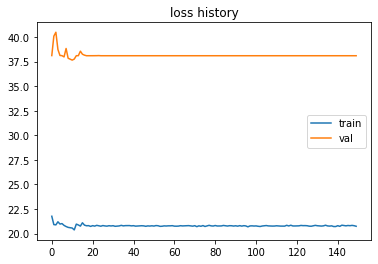

In [21]:
import matplotlib.pyplot as plt
plt.plot(loss_history['train'])
plt.plot(loss_history['val'])
plt.legend(['train','val'])
plt.title('loss history')

Text(0.5, 1.0, 'accuracy history')

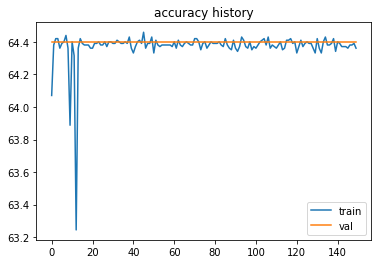

In [22]:
plt.plot(metric_history['train'])
plt.plot(metric_history['val'])
plt.legend(['train','val'])
plt.title('accuracy history')